Filter Methods describe procedures that rely on characteristics in the data for their selection procedures. They look at each feature individually and assess how important they are in prediction.

Filter selection methods use statistical techniques to evaluate the relationship between each input variable and the target variable, and these scores are used as the basis to choose (filter) those input variables that will be used in the model.

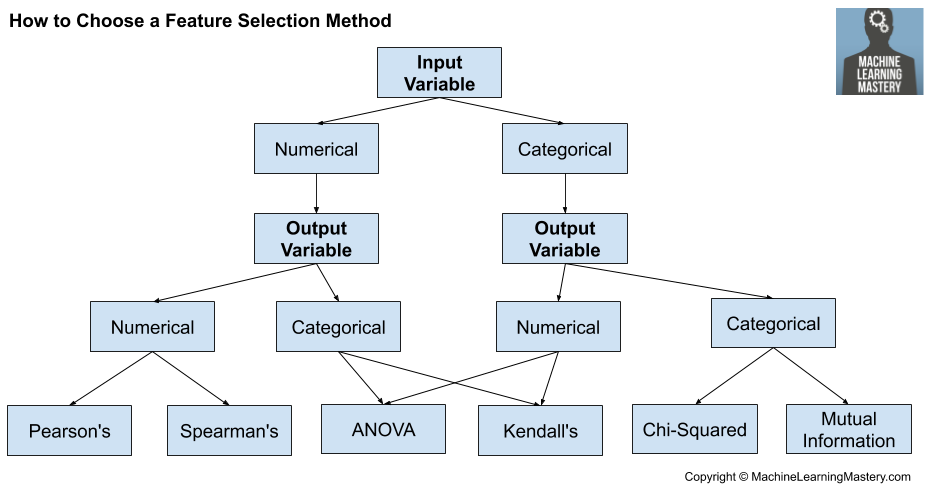

In [45]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import math

from sklearn.ensemble import RandomForestClassifier

os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [46]:
!kaggle datasets download -d amojas00/bank-customer-satisfaction-using-tensorflow

  0% 0.00/4.09M [00:00<?, ?B/s]
100% 4.09M/4.09M [00:00<00:00, 136MB/s]


In [47]:
!unzip \*.zip && rm *.zip

Archive:  bank-customer-satisfaction-using-tensorflow.zip
replace BankCustomer_satisfaction.ipynb? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [48]:
df = pd.read_csv("/content/train.csv", nrows= 20000)
x = df.drop('TARGET', axis= 1)
y = df['TARGET']

### Low Variance Feature - Constant, Quasi-Constant, Duplicated

* Constant Features:  All the values are same
* Quasi-Constant: Only few values are different
* Duplicated: Two or more columns have exactly same values

In [49]:
from sklearn.feature_selection import VarianceThreshold

In [50]:
# Removing Constant Features

print(f"Number of features before removing constant features: {x.shape[1]}")

x1 = x.copy()
const_feature_removed = VarianceThreshold(threshold= 0)
x1 = const_feature_removed.fit_transform(x1)

print(f"Number of features after removing constant feature: {x1.shape[1]}")

Number of features before removing constant features: 370
Number of features after removing constant feature: 306


In [51]:
# Removing Quasi-Constant Features

print(f"Number of features before removing constant features: {x.shape[1]}")

x2 = x.copy()
const_feature_removed = VarianceThreshold(threshold= 0.05) # Remove the features where 95% of the values are same
x2 = const_feature_removed.fit_transform(x1)

print(f"Number of features after removing constant feature: {x2.shape[1]}")

Number of features before removing constant features: 370
Number of features after removing constant feature: 216


In [52]:
# Remove Duplicate Features
# The idea behind finding the duplicate feature is that when the dataframe is transposed the columns will become rows and duplicate rows can be easily
# identified by pandas duplicated() method

x3 = x.copy()
x3_transpose = pd.DataFrame(x3.T)

print(f"Number of features before removing constant features: {x.shape[1]}")
print(f"Shape after transposing: {x3_transpose.shape}")
print(f"Number of duplicate columns: {x3_transpose.duplicated().sum()}")

Number of features before removing constant features: 370
Shape after transposing: (370, 20000)
Number of duplicate columns: 91


In [53]:
duplicate_features = x3_transpose.duplicated()

x3_transpose = x3_transpose.drop(x3_transpose[duplicate_features].index, axis= 0)
x3 = pd.DataFrame(x3_transpose.T)

print(f"Number of features after removing duplicate features: {x3.shape[1]}")

Number of features after removing duplicate features: 279


### Feature Selection using Correlation

What is Pearson Correlation Coefficient?

Correlation between sets of data is a measure of how well they are related. The most common measure of correlation in stats is the Pearson Correlation. The full name is the Pearson Product Moment Correlation (PPMC). It shows the linear relationship between two sets of data.

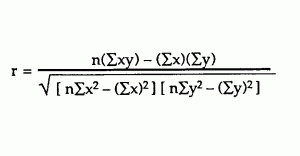

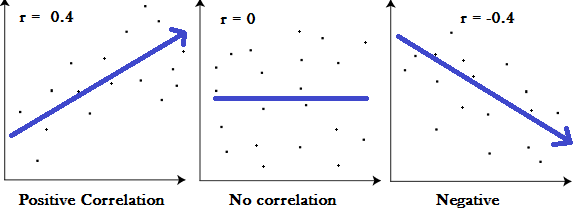

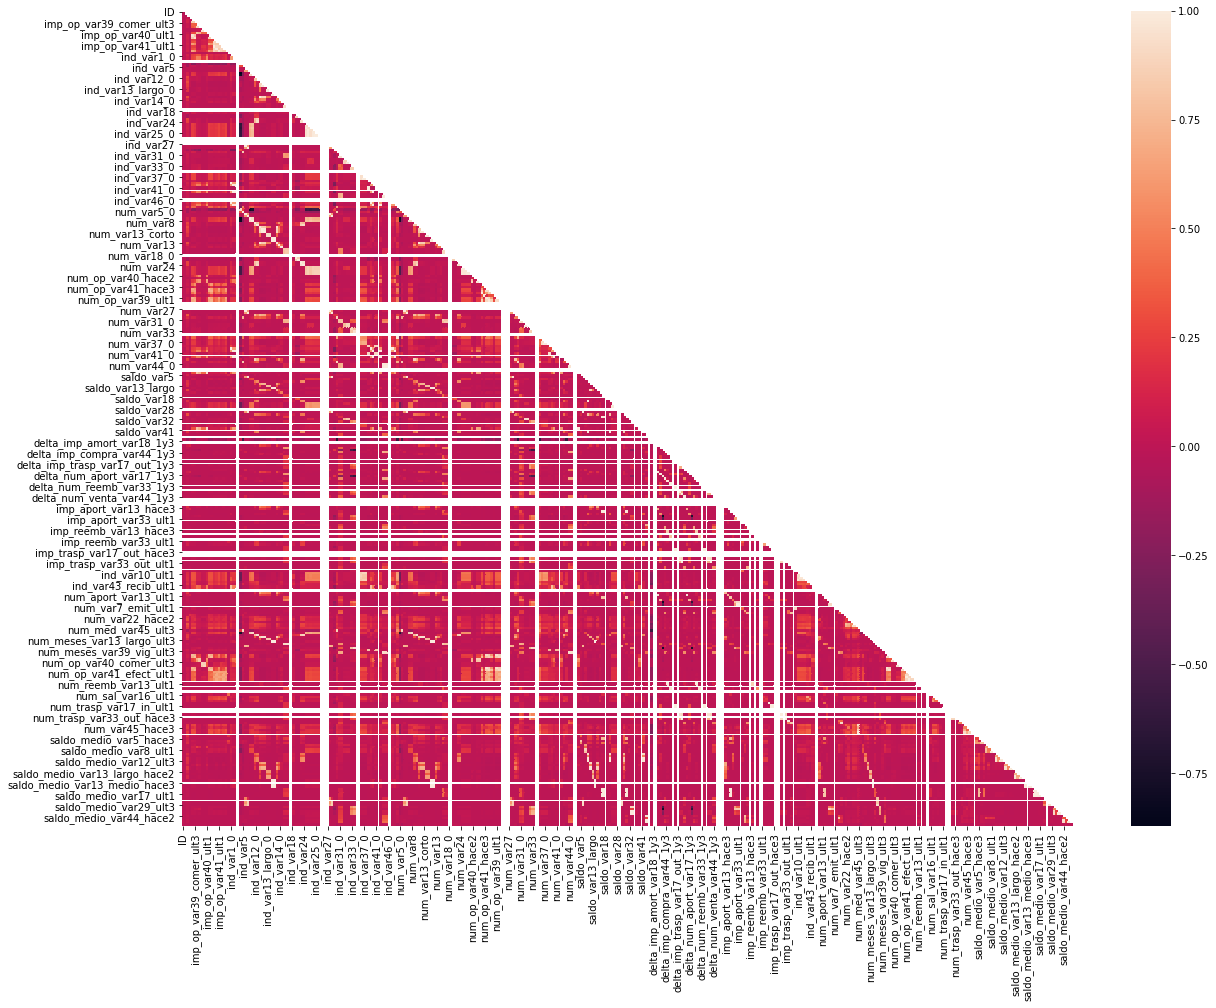

In [54]:
corrmat = x.corr(method= 'pearson')
# It computes pairwise correlation between features by default method is 'pearson' but we can use 'kendall' or 'spearman' also.

# Pearson - Linear Correlation
# Spearsman - Non-Linear Correlation

# ANOVA - Linear Correlation for classification problem
# Kendall - Non-Linear Correlation for classification problem
corrmat_lt = corrmat.where(np.tril(np.ones(corrmat.shape), k = -1).astype(np.bool)) # Getting left triangle of the matrix
plt.figure(figsize = (20,15))
sns.heatmap(corrmat_lt)
plt.show()

In [55]:
# With get_correlation function we can identify the correlated features based on some threshold value.
# But we can't simply remove these features because some of these correlated features might have some importance in predicting the output.
# So, we will create one function where we will check the importance of these features using RandomForest estimator and based on the importance we will remove
# the unimportant features

def get_correlation(input, threshold):
  corr_df = pd.DataFrame(columns= ['Column1', 'Column2', 'Value'])
  for column1 in input.columns:
    for column2 in input.columns:
      if ((math.isnan(input[column1][column2]) == False) & (abs(input[column1][column2]) > threshold)):
        corr_df.loc[len(corr_df.index)] = [column1, column2, input[column1][column2]]
  return corr_df

In [56]:
corr_df = get_correlation(input= corrmat_lt, threshold= 0.85)

In [57]:
corr_df.head(5)

,Column1,Column2,Value
0,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,0.875657
1,imp_op_var39_comer_ult1,imp_op_var41_comer_ult1,0.944760
2,imp_op_var39_comer_ult3,imp_op_var41_comer_ult3,0.949070
3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,0.892199
4,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,0.958607


In [58]:
corr_df.Column1.nunique()

185

In [72]:
def feature_to_remove(corr_dataframe, x, y):
  grouped_feature_list = []
  correlated_groups_list = []
  important_features = []
  columns = corr_dataframe.columns

  for feature in corr_dataframe[columns[0]].unique():
    if feature not in grouped_feature_list:
      correlated_block = corr_dataframe[corr_dataframe[columns[0]] == feature]
      grouped_feature_list = grouped_feature_list + list(correlated_block[columns[1]].unique()) + [feature]
      correlated_groups_list.append(correlated_block)
      
  for group in correlated_groups_list:
    features = list(group[columns[0]].unique()) + list(group[columns[1]].unique())
    rf = RandomForestClassifier(n_estimators=100, random_state=0)
    rf.fit(x[features], y)
    # Here we are using RandomForest Classifier which uses Gini importance to evaluate the feature importance. We can also use p-value and other metrics to check the importance
    importance = pd.concat([pd.Series(features), pd.Series(rf.feature_importances_)], axis = 1)
    importance.columns = ['Features', 'Importance']
    importance.sort_values(by = 'Importance', ascending = False, inplace = True)
    feat = importance.iloc[0]
    important_features = pd.DataFrame(important_features.append(feat))

  features_to_consider = set(important_features['Features'])
  features_to_discard = set(corr_dataframe[columns[0]]) - set(features_to_consider)
  features_to_discard = list(features_to_discard)

  return features_to_discard

In [73]:
features_to_remove = feature_to_remove(corr_dataframe= corr_df, x= x, y= y)

In [74]:
len(features_to_remove)

136

### Mutual Information Gain

In [141]:
from sklearn.feature_selection import mutual_info_classif, SelectPercentile, SelectKBest, chi2
import plotly.graph_objects as go

In [126]:
mi = mutual_info_classif(x, y)

In [135]:
mi_df = pd.DataFrame(columns= ['Features', 'Entropy'])
mi_df['Features'] = x.columns
mi_df['Entropy'] = mi

mi_df.sort_values(by = 'Entropy', ascending = False, inplace = True)
mi_df.reset_index(inplace= True)
mi_df.drop(columns= ['index'], inplace= True)

In [136]:
mi_df

,Features,Entropy
0,var15,0.013100
1,num_var35,0.012288
2,saldo_var30,0.012072
3,ind_var30,0.011863
4,num_var30,0.011041
...,...,...
365,imp_compra_var44_hace3,0.000000
366,imp_compra_var44_ult1,0.000000
367,imp_reemb_var13_hace3,0.000000
368,num_var13_largo_0,0.000000


In [148]:
fig = go.Figure(
    data=[go.Bar(
        y= mi_df.Entropy,
        x= mi_df.Features)],
    layout= go.Layout(
        xaxis_title= "Features",
        yaxis_title= "Entropy"
    ))
fig.show()

### Based on Percentile

In [149]:
sel_feature_percentile = SelectPercentile(mutual_info_classif, percentile= 10)
x4 = x.copy()
x4 = sel_feature_percentile.fit_transform(x4, y)

In [152]:
x4 = pd.DataFrame(x4)

In [155]:
print(f"Number of features before removing based on percentile of mutual info gain: {x.shape[1]}")
print(f"Number of features after removing based on percentile of mutual info gain: {x4.shape[1]}")

Number of features before removing based on percentile of mutual info gain: 370
Number of features after removing based on percentile of mutual info gain: 37
